<a href="https://colab.research.google.com/github/pabloalima81/tcc1/blob/master/cfn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de bibliotecas


In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt
import nltk
from tensorflow.keras import layers
import tensorflow_datasets as tfds


Define a versão do tensorflow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.3.0'

# Pré-processamendo dos dados

Monta o Drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


Nomeia as colunas

In [ ]:
cols = ['label', 'preprocessed_news']

Carrega a base de dados

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cfn/Data/pre-processed.csv', header = None,
                         names = cols, engine = 'python', encoding = 'utf-8')
data.shape


(7200, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


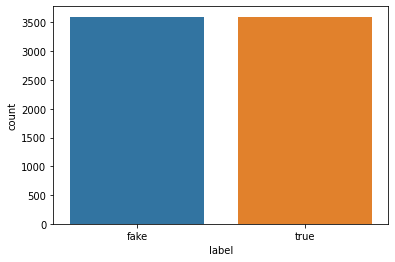

In [ ]:
sns.countplot(data.label);

In [ ]:
data.head()

,label,preprocessed_news
0,fake,katia abreu diz vai colocar expulsao moldura n...
1,fake,ray peita bolsonaro conservador fake entrevist...
2,fake,reinaldo azevedo desmascarado policia federal ...
3,fake,relatorio assustador bndes mostra dinheiro pub...
4,fake,radialista americano fala sobre pt vendem ilus...


In [ ]:
data.tail()

,label,preprocessed_news
7195,true,jornal britanico acao contra lula lava jato se...
7196,true,temer diz acionou pf cade investigar aumentos ...
7197,true,obstaculos politicos temer especialistas ouvid...
7198,true,setembro boa noite aqui estao principais notic...
7199,true,envolvo politica diz brasileiro preso venezuel...


Coloca os previsores(noticias) em X

In [ ]:
X = data.iloc[:, 1].values
X

array(['katia abreu diz vai colocar expulsao moldura nao reclamar senadora katia abreu disse expulsao pmdb resultado acao cupula atual legenda segundo oportunista amanha vou botar moldura dourada expulsao porque maos onde veio atestado boa conduta curriculo pessoas expulsaram nao servem pais servem pais beneficios proprios disse katia abreu ue expulsao algo tao bom curriculo tanta choradeira katia sabemos motivo provavelmente katia nao valor pt partido ja deveria absorvido parece pt gostava katia somente ficasse entrincheirada dentro pmdb rebaixar demais resta katia ficar chorando pitangas todos cantos tempo ate momento pt nao cadastrou katia abreu fileiras situacao patetica agricultura dilma',
       'ray peita bolsonaro conservador fake entrevista danilo gentili divide direita site vem avisando jair bolsonaro deveria abandonar pauta estatista vez fazer discurso convincente boa parte liberais conservadores brasil querem ver livres amarras estatais tudo bem pesquisas ainda dizem maior 

Coloca os classificadores(true or fake) em y

In [ ]:
y = data.iloc[:, 0].values
y

array(['fake', 'fake', 'fake', ..., 'true', 'true', 'true'], dtype=object)

Separa a base em treino e teste. Stratify = y deixa um numero igual de registro para as duas classes

In [ ]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.70, stratify = y)

In [ ]:
X.shape

(2160,)

In [ ]:
data.label.unique()

array(['fake', 'true'], dtype=object)

Verifica o numero de registros em cada classe

In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array(['fake', 'true'], dtype=object), array([1080, 1080]))

Converte os valores das classes em zero e um

In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 'true'] = 1
data_labels[data_labels == 'fake'] = 0
data_labels

array([0, 0, 0, ..., 1, 0, 1], dtype=object)

In [ ]:
np.unique(data_labels)

array([0, 1], dtype=object)

# Tokenização

In [ ]:
import math
math.pow(2, 16)

65536.0

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(X, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size

48592

In [ ]:
print (tokenizer.subwords)

['nao_', 'lula_', 'ser_', 'sao_', 'presidente_', 'tambem_', 'disse_', 'anos_', 'ja_', 'sobre_', 'federal_', 'governo_', 'ainda_', 'r_', 'segundo_', 'brasil_', 'temer_', 'pais_', 'ate_', 'ha_', 'diz_', 'ter_', 'contra_', 'pessoas_', 'pode_', 'dia_', 'ano_', 'vai_', 'apos_', 'caso_', 'porque_', 'milhoes_', 'acordo_', 'justica_', 'afirmou_', 'estado_', 'publico_', 'so_', 'dois_', 'policia_', 'dilma_', 'ministro_', 'paulo_', 'dinheiro_', 'fazer_', 'lava_', 'jato_', 'processo_', 'ministerio_', 'defesa_', 'estao_', 'hoje_', 'durante_', 'todos_', 'voce_', 'sera_', 'odebrecht_', 'rio_', 'outros_', 'parte_', 'mil_', 'casa_', 'decisao_', 'operacao_', 'empresa_', 'nesta_', 'pt_', 'alem_', 'onde_', 'seguranca_', 'camara_', 'desde_', 'republica_', 'tribunal_', 'politica_', 'agora_', 'juiz_', 'moro_', 'grande_', 'corrupcao_', 'qualquer_', 'entao_', 'tres_', 'stf_', 'apenas_', 'maior_', 'nacional_', 'vez_', 'lei_', 'outro_', 'antes_', 'mundo_', 'denuncia_', 'prisao_', 'sido_', 'grupo_', 'forma_', 'di

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in X]

In [ ]:
for _ in range(20):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[112, 1225, 2185, 11623, 11958, 105, 7762, 126, 686, 1722, 2718, 49, 105, 13835, 39, 877, 1413, 2122, 71, 6185, 989, 949, 197, 112, 1225, 4191, 2185, 11623, 46167, 7276, 1722, 999, 2823, 1, 3584, 2253, 1440, 1441, 595, 114, 1, 14084, 26862, 49, 19, 621, 21892, 910, 20, 1850, 286, 5, 130, 17, 614, 551, 105, 2122, 42, 2752, 4600, 265, 1989, 1722, 4722, 1957, 152, 1321, 989, 242, 5, 2122, 334, 2592, 878, 71, 7311, 7155, 150, 4831, 4747, 800, 6931, 755, 1429, 122, 100, 76, 1557, 17, 5, 5649, 408, 191, 334, 2592, 2494, 1273, 785, 686, 1722, 9, 2154, 954, 141, 368, 2216, 1321, 285, 17, 435, 146, 42, 686, 4607, 1722, 1855, 4, 814, 679, 12, 2404, 4245, 3901, 4245, 1, 85, 3878, 1869, 1321, 2192, 9188, 587, 19924, 447, 292, 41, 274, 1241, 557, 71, 1631, 1579, 19, 52, 5190, 433, 41, 5061, 1490, 3560, 8640, 17, 517, 1323, 1722, 43152, 285, 5, 73, 2323, 13277, 31772]
[17, 11921, 395, 200, 595, 5, 6195, 903, 2802, 305, 29, 1000, 779, 921, 256, 423, 6182, 192, 5, 25, 2377, 127, 703, 373, 2419, 130, 1

# Padding
Preenche as sentenças deixando todas com mesmo tamanho

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

4164

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value = 0, padding = 'post', maxlen=max_len)

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  30 4435   56 ...    0    0    0]
[   48 16643  7496 ...     0     0     0]
[5010 2315   73 ...    0    0    0]
[ 158   93 8115 ...    0    0    0]
[  68  270 1596 ...    0    0    0]
[ 4781  8662 12329 ...     0     0     0]
[ 67   9 118 ...   0   0   0]
[1115  747 5502 ...    0    0    0]
[658  40  41 ...   0   0   0]
[69 40 41 ...  0  0  0]


# Divisao da Base de dados

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [ ]:
train_inputs.shape

(1512, 4229)

In [ ]:
train_labels.shape

(1512,)

In [ ]:
test_inputs.shape

(648, 4229)

In [ ]:
test_labels.shape

(648,)

# Model

In [ ]:
class DCNN(tf.keras.Model):
  
  #0 Construtor da classe com passagem de parâmetros
  def __init__(self,
               vocab_size, #Tamanho do vocabulário
               emb_dim=128, # Tamanho da matriz de embbedings
               nb_filters=50, #Número de filtros por região
               ffn_units=512, #Feedforward - Número de neuronios da Rede neural densa
               dropout_rate=0.1, #Zera percentual de neurônios para evitar overfetting
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)
    #1 Gera matriz de palavras
    self.embedding = layers.Embedding(vocab_size, emb_dim)
    #2 Gera os filtros de tamanho 2
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')
    #2.1 Gera os filtros de tamanho 3
    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')
    #2.2 Gera os filtros de tamanho 4
    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')
    #3 Etapa de maxpooling
    self.pool = layers.GlobalMaxPool1D()

    #4 Rede neural densa com ffn_unit definindo o numero de neuronios e função de ativação relu
    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    #4.1 Passagem do parametro de dropout para evitar overfetting
    self.dropout = layers.Dropout(rate = dropout_rate)
    #4.2 Define a camada de saída com 1 bit e função de ativação sigmoid
    self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')

  #Função que faz a "conexão" dos objetos da rede
  def call(self, inputs, training):
    #Matriz de palavras recebe o texto
    x = self.embedding(inputs)
    #Filtros da região 3 recebem a matriz de palavras
    x_1 = self.bigram(x)
    #Executa o maxpooling no bigram
    x_1 = self.pool(x_1)
    #Filtros da região 2 recebem a matriz de palavras
    x_2 = self.trigram(x)
    #Executa o maxpooling no trigram
    x_2 = self.pool(x_2)
    #Filtros da região 2 recebem a matriz de palavras
    x_3 = self.fourgram(x)
    #Executa o maxpooling no fourgram
    x_3 = self.pool(x_3)
    #Faz a concatenação após o max pooling
    merged = tf.concat([x_1, x_2, x_3], axis = -1) # Return (batch_size, número de camadas (3) * nb_filters)
    #A camada primeira camada densa recebe o vetor concatenado
    merged = self.dense_1(merged)
    #Zera uma porção dos neurônios
    merged = self.dropout(merged, training)
    #Liga a camada de dropout a camada de saída
    output = self.last_dense(merged)

    return output

# Treinamento

## Parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

48592

In [ ]:
emb_dim = 128
nb_filters = 50
ffn_units = 512
batch_size = 64

2

In [ ]:
dropout_rate = 0.1
nb_epochs = 3

## Treino

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [ ]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Salva a rede treinada ou restaura última versão salva

In [ ]:
checkpoint_path = "./content/drive/My Drive/Colab Notebooks/cfn"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
train_inputs=train_inputs.astype(np.int64)
train_labels=train_labels.astype(np.int64)
test_inputs=test_inputs.astype(np.int64)
test_labels=test_labels.astype(np.int64)

In [ ]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/3
22/22 [==============================] - 149s 7s/step - loss: 0.6360 - accuracy: 0.6529 - val_loss: 0.4994 - val_accuracy: 0.9605
Epoch 2/3
22/22 [==============================] - 150s 7s/step - loss: 0.2622 - accuracy: 0.9713 - val_loss: 0.1391 - val_accuracy: 0.9737
Epoch 3/3
22/22 [==============================] - 151s 7s/step - loss: 0.0411 - accuracy: 0.9934 - val_loss: 0.0866 - val_accuracy: 0.9671


'./content/drive/My Drive/Colab Notebooks/cfn/ckpt-1'

# Avaliação

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

11/11 [==============================] - 17s 2s/step - loss: 0.1185 - accuracy: 0.9568
[0.11854111403226852, 0.9567901492118835]


In [ ]:
y_pred_test = Dcnn.predict(test_inputs)


In [ ]:
y_pred_test

array([[5.69265425e-01],
       [9.99538660e-01],
       [9.78585482e-01],
       [9.68560934e-01],
       [8.80924582e-01],
       [9.36731696e-01],
       [3.80221009e-03],
       [5.86527586e-03],
       [9.97707605e-01],
       [2.25155950e-02],
       [8.42724144e-01],
       [7.22643495e-01],
       [6.23697042e-03],
       [3.08627188e-02],
       [1.74286962e-03],
       [9.96300340e-01],
       [5.65191507e-02],
       [3.41305137e-03],
       [1.28477812e-03],
       [2.72106826e-02],
       [9.48940635e-01],
       [9.92321968e-01],
       [9.83483315e-01],
       [1.19979084e-02],
       [3.40023637e-02],
       [9.57705498e-01],
       [9.99796987e-01],
       [4.36607003e-03],
       [3.34878266e-02],
       [1.89420581e-03],
       [9.96903062e-01],
       [9.98738885e-01],
       [9.90706444e-01],
       [1.11989081e-02],
       [5.20926714e-03],
       [2.52097845e-03],
       [6.25091791e-03],
       [9.38477159e-01],
       [9.11256433e-01],
       [1.36370361e-02],


In [ ]:
y_pred_test = (y_pred_test > 0.5)

In [ ]:
y_pred_test

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [

In [ ]:
test_labels

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[305,  19],
       [  9, 315]])

Text(0.5, 1.0, 'Matriz de confusão do classificador')

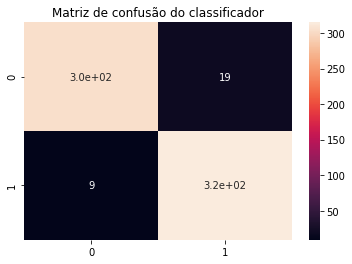

In [ ]:
sns.heatmap(cm, annot=True)
plt.title('Matriz de confusão do classificador')

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

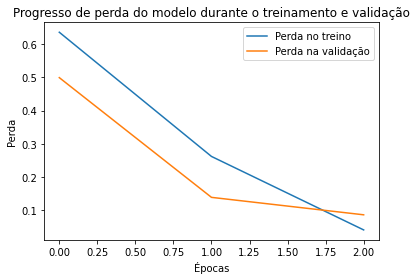

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Progresso de perda do modelo durante o treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Perda no treino', 'Perda na validação'])

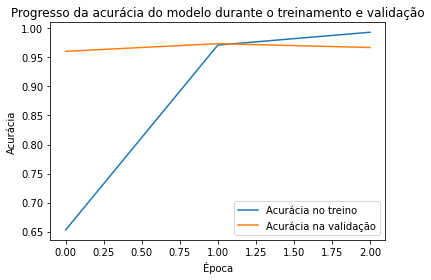

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Progresso da acurácia do modelo durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend(['Acurácia no treino', 'Acurácia na validação'])

# Previsões

In [ ]:
text = 'ELES CONSEGUIRAM COM O AVAL DAS URNAS FRAUDULENTAS!!!! VOCÊS ESQUECERAM QUE O PALOCCI FALOU???? ELES DECIDEM ATRAVÉS DAS URNAS FRAUDADAS, QUEM VAI GANHAR.... SIMPLES ASSIM!!!!! MAS PARECE QUE O POVO JÁ SE ESQUECEU DA DELAÇÃO DO PALOCCI!!! ELEIÇÃO NO BRASIL SÓ. MANIPULAÇÃO!!! POR ISSO NÃO QUEREM VOTO IMPRESSO, PARA PODEREM ROUBAR A VONTADE CULPA DO POVO QUE NÃO VAI ÀS RUAS EXIGIR VOTO IMPRESSO!!! OU ALGUÉM CONFIA NESTE STE (sic) DO BARROSO E TODOS OS URUBUS DO STF???'
text = clean_text(clean_sw(text))
print(text)
text = tokenizer.encode(text)

eles conseguiram com o aval das urnas fraudulentas!!!! voc s esqueceram que o palocci falou???? eles decidem atrav s das urnas fraudadas quem vai ganhar.... simples assim!!!!! mas parece que o povo j se esqueceu da dela o do palocci!!! elei o no brasil s . manipula o!!! por isso n o querem voto impresso para poderem roubar a vontade culpa do povo que n o vai s ruas exigir voto impresso!!! ou algu m confia neste ste sic do barroso e todos os urubus do stf???


In [ ]:
pred= Dcnn(np.array([text]), training=False).numpy()
pred = (pred > 0.5)
print(pred)

[[ True]]


# Limpeza dos dados

## Remove Caracteres especiais

In [ ]:
def clean_text(text):
  text = BeautifulSoup(text, 'lxml').get_text()
  text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
  text = re.sub(r"[^a-zA-Z.!?]", ' ', text)
  text = re.sub(r" +", ' ', text)
  return text

## Remove Stop Words

In [ ]:
!python -m spacy download pt

     |████████████████████████████████| 21.2MB 1.2MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186282 sha256=bf2875561e935bb9739522c670262d50c001fd469b550fdce057e3dc696f026e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ouevn1p5/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
nlp = sp.load('pt')
nlp

In [ ]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


204

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_sw(text):
  text = text.lower()
  document = nlp(text)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stopwords and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return text